# Visibility Gridding

For this first tutorial, I'll show how to access a CASA Measurement Set and how to grid the visibilities. I'll use the RULup protoplanetary disk for the example in this notebook, but the same approach can be applied for any protoplanetary disk of the DSHARP survey.  


### Accessing data in a Measurement Set
Our first step will be to get the visibilities and their $uv$ coordinates in the Measurement Set. Let's first download the Measurement set from the [DSHARP data release](https://almascience.eso.org/almadata/lp/DSHARP/). For clarity, we can create a directory to store the data from this notebook. 

In [2]:
import wget
import tarfile
import os

# RULup measurement set url
url = "https://almascience.eso.org/almadata/lp/DSHARP/MSfiles/RULup_continuum.ms.tgz"

# Creating data folder
data_folder = "data" 
os.makedirs(data_folder, exist_ok=True)
disk = "RULup_continuum"
fname_tgz = os.path.join(data_folder, f"{disk}.ms.tgz")
fname = os.path.join(data_folder, f"{disk}.ms")

if not os.path.exists(fname_tgz):
    wget.download(url, fname)

# Extracting the tar file
if not os.path.exists(fname): 
    with tarfile.open(fname) as f:
        f.extractall(path=data_folder) 

Once the data downloaded, we can access the data using the packages `casatasks` and `visread` packages. They can be installed on Python 3.8, using the requirement_casa.txt file in the repository. 

Since our objective is to perform continuum imaging, we combine visibility measurements from all spectral windows. This can be done as follows 

In [2]:
from casatools import msmetadata
from visread import process
from tqdm import tqdm
import numpy as np

# get all spws
msmd = msmetadata()
msmd.open(fname)
spws = msmd.datadescids()
msmd.done()

uu = []
vv = []
weight_ls = []
data = []
vis_per_spw = []
freq_per_spw = []
sigma_rescale_spw = []
num_chans = []


print("Iterating over spectral windows...")
for spw in tqdm(spws):
    # No rescaling. 
    sigma_rescale=1.

    # Get visibilities
    d = process.get_processed_visibilities(fname, spw, sigma_rescale=1.0) # Jy
    flag = d["flag"]
    chan_freq = d["frequencies"] # Hertz
    nchan = len(chan_freq)
    u = d["uu"] # meters
    v = d["vv"] # meters

    # Broadcasting shapes so that they are (nchan, N_vis) == flag.shape
    weight = d["weight"] 
    broadcasted_weight = weight * np.ones(shape = (nchan, weight.shape[0]))

    # Convert the uv points to klambdas given the channel frequency
    u, v = process.broadcast_and_convert_baselines(u, v, chan_freq) 

    # Applying the flag mask flattens each array:
    uu.append(u[~flag])
    vv.append(v[~flag])
    weight_ls.append(broadcasted_weight[~flag])
    data.append(d["data"][~flag])
    freq_per_spw.append(chan_freq)
    vis_per_spw.append(len(u[~flag]))
    sigma_rescale_spw.append(sigma_rescale)
    num_chans.append(len(chan_freq))
    
uu = np.concatenate(uu)
vv = np.concatenate(vv)
weight = np.concatenate(weight_ls)
data = np.concatenate(data)
vis_per_spw = np.array(vis_per_spw)
freq_per_spw = np.concatenate(freq_per_spw)
num_freq_per_spw = np.array(num_chans)

2024-12-10 13:06:29	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on data/RULup_continuum.ms...


Iterating over spectral windows...


100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


The extracted data can be saved in .npz format for a more convenient usage. To convert a folder containing multiple Measurement Sets into corresponding .npz files, you can use the script `ms_to_npz.py` in the `scripts` folder.   

## Gridding the visibilities. 
Our objective is now to assign visibility values on a pixel grid. We use convolutional gridding with a sinc window function for its uniform effet in image space. We define our grid with an odd number of pixels. Assigning a pixel to the flux parameter in uv space helped IRIS to achieve better residuals in practice. The gridding operatrtion can be done as follows in our pipeline. 

Our current implementation is quite slow ($\sim 40$ min to grid one Measurement Set), but we are working on optimizing it to improve efficiency in the near future.

In [3]:
import sys
sys.path.append("../src")
from preprocessing.gridding import bin_data, grid, sinc_window
from functools import partial
import json

with open("../dsharp_params.json", 'r') as file:
    dict_disks_info = json.load(file) 
disk_info = dict_disks_info[disk]
pixel_scale = disk_info['pixel_scale'] # pixel size in image space (arcsec)

# Hermitian augmentation:
uu = np.concatenate([uu, -uu])
vv = np.concatenate([vv, -vv])
vis_re = np.concatenate([data.real, data.real])
vis_imag = np.concatenate([data.imag, -data.imag])
weight_ = np.concatenate([weight, weight])

print(f"The measurement set contains {len(uu)} data points")
npix = 4097 # size of the pixel grid (npix x npix). Odd number of pixels for
u_edges, v_edges = grid(pixel_scale = pixel_scale, npix = npix)

delta_u = u_edges[1] - u_edges[0]
truncation_radius = delta_u

window_fn = partial(sinc_window, pixel_size=delta_u)

# Real part
params = (uu, vv, vis_re, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_re = bin_data(*params, statistics_fn="mean", verbose=1) # Jy/pixel
std_bin_re = bin_data(*params, statistics_fn="std", verbose=1) # Jy/pixel

# Imaginary part
params = (uu, vv, vis_imag, weight_, (u_edges, v_edges), window_fn, truncation_radius)
vis_bin_imag = bin_data(*params, statistics_fn="mean", verbose=1) # Jy/pixel
std_bin_imag = bin_data(*params, statistics_fn="std", verbose=1) # Jy/pixel

# Count: 
counts = bin_data(*params, statistics_fn="count", verbose=1)

The measurement set contains 71389260 data points
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4097/4097 [03:54<00:00, 17.50it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4097/4097 [06:23<00:00, 10.69it/s]


number of coarsened pix: 36742
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4097/4097 [03:53<00:00, 17.51it/s]


number of coarsened pix: 0
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4097/4097 [06:21<00:00, 10.73it/s]


number of coarsened pix: 36742
Fitting the KD Tree on the data...
Gridding...


100%|██████████| 4097/4097 [03:55<00:00, 17.42it/s]

number of coarsened pix: 0


Great ! We now have our gridded visibilities. We can plot the dirty image (which is going to be $4097\times 4097$ pixels) to check if we can see some features from the RuLup protoplanetary disk. 

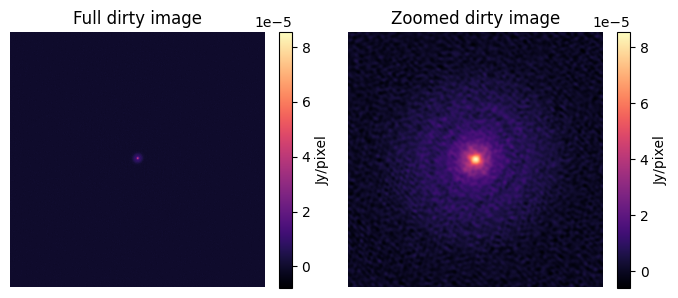

In [7]:
from visualization import compute_dirty_image
import matplotlib.pyplot as plt

vis_grid = vis_bin_re + 1j * vis_bin_imag
dirty_image = compute_dirty_image(vis_grid) # this is a real array by default.

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

for ax in axs: 
    ax.axis("off")

im = axs[0].imshow(dirty_image, cmap = "magma", origin = "lower")
axs[0].set_title("Full dirty image")
cbar = plt.colorbar(im, fraction = 0.0455)
cbar.set_label(r"Jy/pixel")

img_size = 256
# Centering the image on the protoplanetary disk
max_index = dirty_image.argmax()
pixel_center_h = max_index // npix + disk_info["offset_h"]
pixel_center_w = max_index % npix + disk_info["offset_w"]
Dh, Uh = pixel_center_h - img_size//2, pixel_center_h + img_size//2 
Dw, Uw = pixel_center_w - img_size//2, pixel_center_w + img_size//2 
im = axs[1].imshow(dirty_image[Dh:Uh, Dw:Uw], cmap = "magma", origin = "lower")
cbar = plt.colorbar(im, fraction = 0.0455)
axs[1].set_title("Zoomed dirty image")
cbar.set_label(r"Jy/pixel")

Perfect. The final step of this notebook will be to prepare the data for the inference. We will need to obtain from our previous code these different elements: 
1) Observation (sampled visibilities) $\mathcal{V}$. We additionnaly use a vectorized representation of complex variables here, by defining $\mathcal{V}=(\mathrm{Re}(\mathcal{V}), \mathrm{Im}(\mathcal{V}))$. We will also need a standard deviation estimate for our visibilities (Gaussian noise). 
2) Sampling function $S$
3) A rescaling factor $B$ to ensure coverage from our SBM. 
4) A padding term (which is going to be uneven, in order to center the protoplanetary disk properly). This term is used to increase resolution in Fourier space. It is important since our score model has a finite resolution. 
5) Mean frequency of the observation. This will allows us to compute the primary beam $P$.  

In [16]:
import h5py

S = counts > 0 # sampling function, i.e. 2D bool mask. 
B, C = dirty_image.max().item() / disk_info['probes_norm'], 0

# Uneven padding
pad_b = (pixel_center_h - img_size // 2)
pad_t = npix - (pixel_center_h + img_size // 2)
pad_l = (pixel_center_w - img_size // 2)
pad_r = npix - (pixel_center_w + img_size // 2)
pad = (pad_l, pad_r, pad_b, pad_t)

# Sampled visibilities + noise estimate
vis_sampled = np.concatenate([vis_bin_re[S], vis_bin_imag[S]])
std_sampled = np.concatenate([std_bin_re[S], std_bin_imag[S]])

# Save data as an h5 file
filename = os.path.join(data_folder, f"{disk}_preprocessed.h5")
with h5py.File(filename, "w") as h5f:
    h5f.create_dataset("vis", data=vis_sampled)
    h5f.create_dataset("vis_noise", data=std_sampled)
    h5f.create_dataset("sampling_function", data=S) 
    h5f.create_dataset("B", data=B)
    h5f.create_dataset("pad", data=pad)
    h5f.create_dataset("freq", data=freq_per_spw.mean())